# Lag-Llama Fine Tuning

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [1]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 505 (delta 153), reused 108 (delta 108), pack-reused 314 (from 3)
Receiving objects: 100% (505/505), 283.34 KiB | 1.20 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [43]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip uninstall jax jaxlib tensorboard -y

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [4]:
!pip install -U -r requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 192MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [6]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-6-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [8]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

## Zero Shot on `M4-Weekly`

In [9]:
dataset = get_dataset("m4_weekly")

In [20]:
print(dataset.metadata.prediction_length)

13


In [11]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = "cuda"

In [16]:
# prompt: load dataset into pandas dataframe

# Convert the integer index to a DatetimeIndex with a dummy start date and frequency.
# We are doing this because infer_freq is unable to determine the freq from integer values
# This approach does not support uneven timestamps in the original dataset.
train_df = pd.DataFrame(dataset.train)

test_df = pd.DataFrame(dataset.test)


In [41]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x78c017cd31d0>, iterable=JsonLinesFile(path=PosixPath('/root/.gluonts/datasets/m4_weekly/train/data.json.gz'), start=0, n=None, line_starts=[np.int16(0), np.int16(17705), np.int16(31710), np.int16(-18807), np.int16(832), np.int16(12140), np.int16(22512), np.int16(-31577), np.int16(-20119), np.int16(-8144), np.int16(-1096), np.int16(6044), np.int16(9293), np.int16(15497), np.int16(21675), np.int16(26900), np.int16(32125), np.int16(-27521), np.int16(-22065), np.int16(-10621), np.int16(675), np.int16(11983), np.int16(23420), np.int16(-31661), np.int16(-19853), np.int16(-8615), np.int16(2887), np.int16(14184), np.int16(25604), np.int16(-28844), np.int16(-17526), np.int16(-6673), np.int16(4806), np.int16(16106), np.int16(27244), np.int16(-27049), np.int16(-20233), np.int16(-16591), np.int16(-12861), np.int16(-1850), np.int16(9378), np.int16(17286), np.int16(25174), np.int16(-32029), np.int16(-21029), np.int16(-10941), np.int16(-2293

In [26]:
print(train_df['target'][0])

[ 1089.2   1078.91  1079.88 ... 36565.18 36565.18 35397.16]


In [12]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

In [39]:
len(forecasts)

359

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 350, 355):
    ax = plt.subplot(4, 4, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

ValueError: num must be an integer with 1 <= num <= 16, not 351

<Figure size 2000x1500 with 0 Axes>

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [50]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [64]:
import pandas as pd

data_dir = '/content/drive/MyDrive/Batteries/more_data/total/b1c0_for_model.csv'  # adjust if needed
df_mine = pd.read_csv(data_dir, parse_dates=True)
df_mine

,cycle_index,charge_capacity,discharge_capacity,internal_resistance,temperature_mean,temperature_min,temperature_max
0,3.0,1.071674,1.071900,0.016724,31.931490,29.604385,35.692978
1,4.0,1.072304,1.072510,0.016681,31.932603,29.744202,35.680588
2,5.0,1.072970,1.073174,0.016662,31.959322,29.644709,35.728691
3,6.0,1.073491,1.073576,0.016623,31.961062,29.752932,35.711758
4,7.0,1.073922,1.073992,0.016600,31.900562,29.564377,35.615650
...,...,...,...,...,...,...,...
1844,1847.0,0.885568,0.885435,0.018263,32.432079,31.080084,35.415527
1845,1848.0,0.884639,0.884546,0.018619,31.683310,28.951157,36.136974
1846,1849.0,0.884495,0.884624,0.018133,32.700542,30.243074,36.786781
1847,1850.0,0.884329,0.884331,0.018123,32.990592,30.337559,36.923153


In [65]:
import numpy as np

df_mine['timestamp'] = pd.to_datetime(
        df_mine['cycle_index'],
        unit='D',
        origin=pd.Timestamp("2000-01-01")
    )
df_mine = df_mine.set_index('timestamp')

# Drop the now-unneeded cycle_index column
df_mine = df_mine.drop(columns=['cycle_index'])

# Convert numerical columns to float 32 format for lag-llama
for col in df_mine.columns:
    # Check if column is not of string type
    if df_mine[col].dtype != 'object' and pd.api.types.is_string_dtype(df_mine[col]) == False:
        df_mine[col] = df_mine[col].astype('float32')
#print(dict(df_mine))
# Create a PandasDataset
ds = PandasDataset(dict(df_mine))

backtest_dataset = ds
device = torch.device("cuda:0")

In [68]:
backtest_dataset

PandasDataset<size=6, freq=D, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [69]:
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [70]:
predictor = estimator.train(backtest_dataset, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Tra

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.68657 (best 0.68657), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.68657 (best 0.68657), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.38293 (best -0.38293), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.38293 (best -0.38293), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO: Epoch 3, global step 200: 'trai

In [106]:
data_dir = '/content/drive/MyDrive/Batteries/more_data/total/b3c0_for_model.csv'  # adjust if needed
df_mine = pd.read_csv(data_dir, parse_dates=True)

df_mine['timestamp'] = pd.to_datetime(
        df_mine['cycle_index'],
        unit='D',
        origin=pd.Timestamp("2000-01-01")
    )
df_mine = df_mine.set_index('timestamp')

# Drop the now-unneeded cycle_index column
df_mine = df_mine.drop(columns=['cycle_index'])

# Convert numerical columns to float 32 format for lag-llama
for col in df_mine.columns:
    # Check if column is not of string type
    if df_mine[col].dtype != 'object' and pd.api.types.is_string_dtype(df_mine[col]) == False:
        df_mine[col] = df_mine[col].astype('float32')
#print(dict(df_mine))
# Create a PandasDataset
ds = PandasDataset(dict(df_mine))

test = ds
device = torch.device("cuda:0")

In [107]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test,
        predictor=predictor,
        num_samples=num_samples
    )

In [108]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [109]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

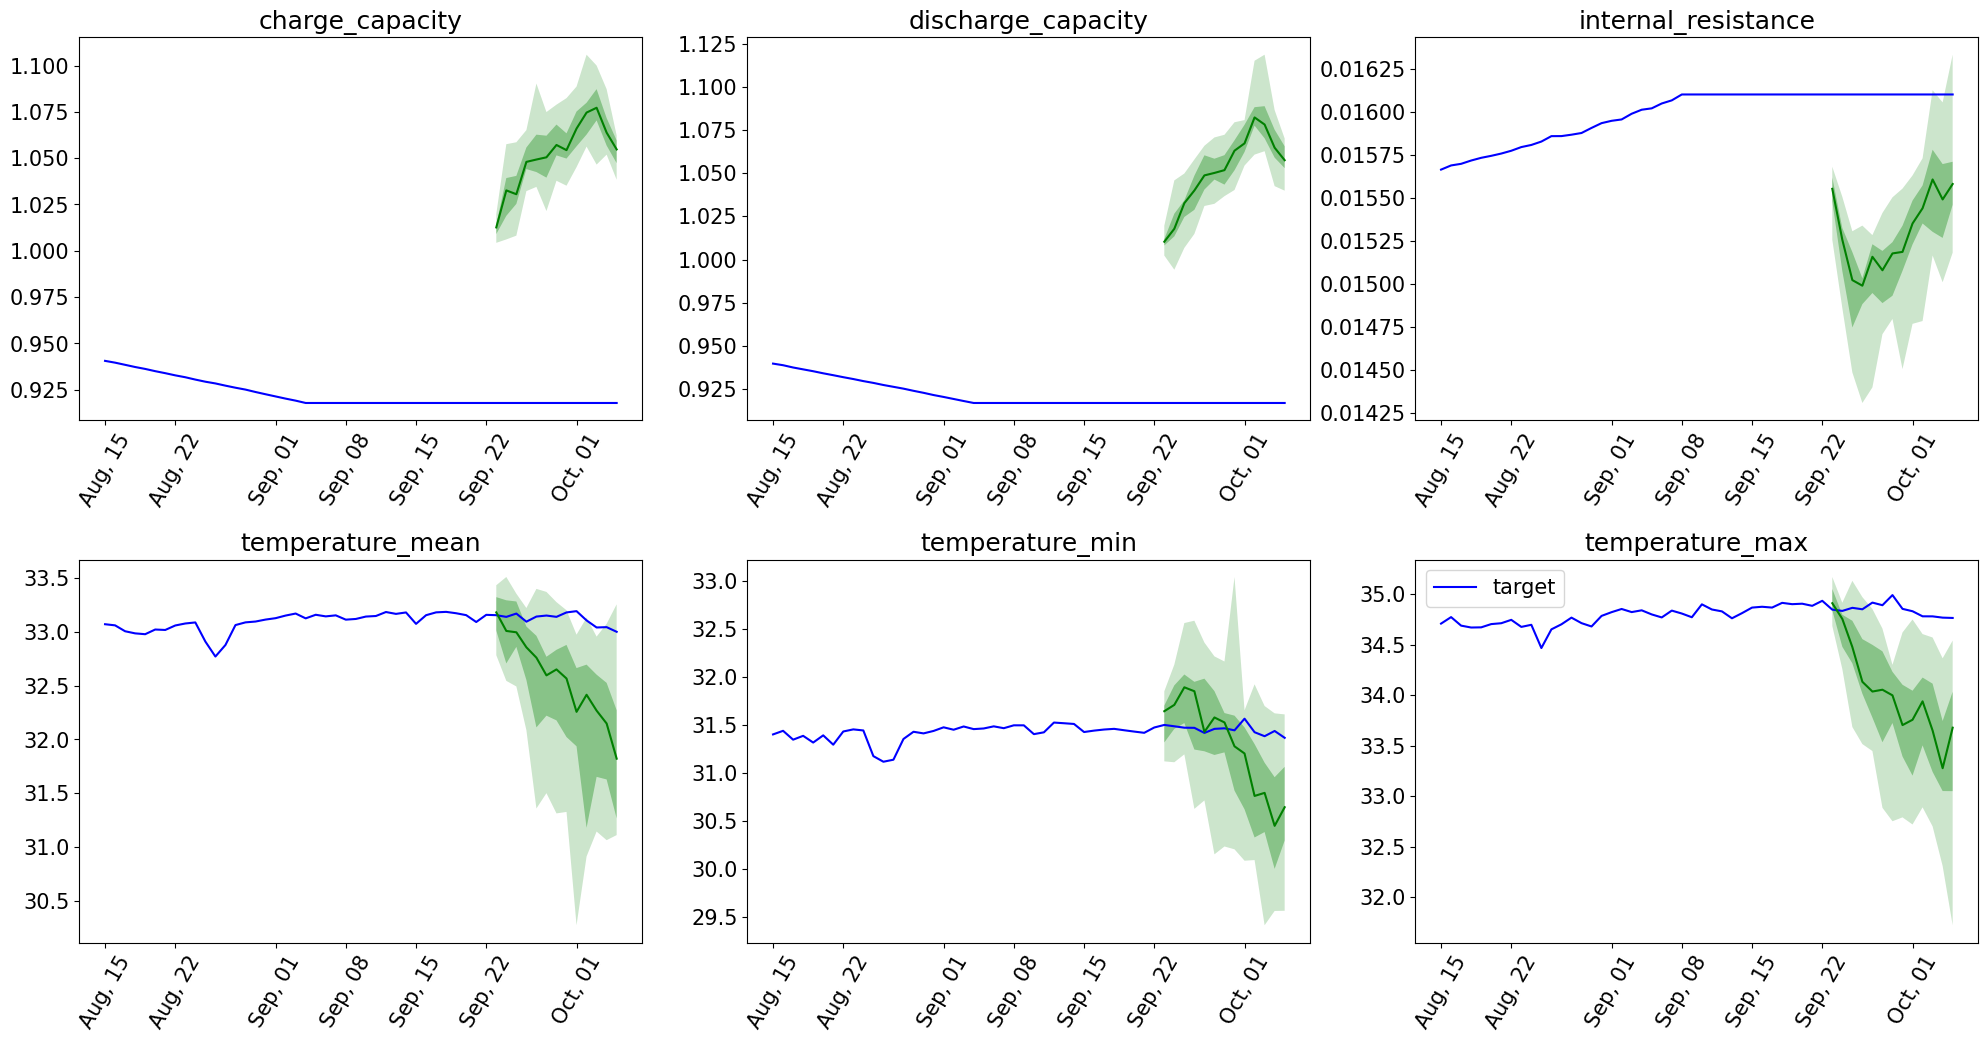

In [115]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", color='b' )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [111]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 6it [00:00, 330.82it/s]


In [112]:
agg_metrics #old

{'MSE': np.float64(0.29347622372771204),
 'abs_error': np.float64(26.17524893861264),
 'abs_target_sum': np.float64(1316.4785988777876),
 'abs_target_mean': np.float64(16.87793075484343),
 'seasonal_error': np.float64(0.02206859294270661),
 'MASE': np.float64(267.9117837726065),
 'MAPE': np.float64(0.06564695311662479),
 'sMAPE': np.float64(0.06260803895883073),
 'MSIS': np.float64(8186.609663422588),
 'num_masked_target_values': np.float64(0.0),
 'QuantileLoss[0.1]': np.float64(15.364096958190204),
 'Coverage[0.1]': np.float64(0.3333333333333333),
 'QuantileLoss[0.2]': np.float64(20.739015332981946),
 'Coverage[0.2]': np.float64(0.3333333333333333),
 'QuantileLoss[0.3]': np.float64(23.8102002048865),
 'Coverage[0.3]': np.float64(0.358974358974359),
 'QuantileLoss[0.4]': np.float64(25.98861222267151),
 'Coverage[0.4]': np.float64(0.38461538461538464),
 'QuantileLoss[0.5]': np.float64(26.17524905782193),
 'Coverage[0.5]': np.float64(0.44871794871794873),
 'QuantileLoss[0.6]': np.float64

In [77]:
agg_metrics #new

{'MSE': np.float64(0.22336231623195638),
 'abs_error': np.float64(19.31855797767639),
 'abs_target_sum': np.float64(1306.121940717101),
 'abs_target_mean': np.float64(16.74515308611668),
 'seasonal_error': np.float64(0.16776286794936843),
 'MASE': np.float64(1.6076078545611476),
 'MAPE': np.float64(0.011607812287715765),
 'sMAPE': np.float64(0.011679196778016212),
 'MSIS': np.float64(20.491783108424265),
 'num_masked_target_values': np.float64(0.0),
 'QuantileLoss[0.1]': np.float64(8.980524956062437),
 'Coverage[0.1]': np.float64(0.07692307692307693),
 'QuantileLoss[0.2]': np.float64(14.405949026346207),
 'Coverage[0.2]': np.float64(0.12820512820512822),
 'QuantileLoss[0.3]': np.float64(17.339868161827326),
 'Coverage[0.3]': np.float64(0.21794871794871798),
 'QuantileLoss[0.4]': np.float64(19.1963324919343),
 'Coverage[0.4]': np.float64(0.3461538461538461),
 'QuantileLoss[0.5]': np.float64(19.31855797767639),
 'Coverage[0.5]': np.float64(0.4871794871794872),
 'QuantileLoss[0.6]': np.fl